In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm, tqdm_pandas
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime
import nltk
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.stats import skew
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())


0it [00:00, ?it/s]


In [3]:
# Load in data
column_names = ['ID', 'Title', 'From', 'To', 'House', 'Term', 'Session', 'Meeting',
       'Sitting', 'Agenda', 'Subcorpus', 'Speaker_role', 'Speaker_type',
       'Speaker_party', 'Speaker_party_name', 'Party_status', 'Speaker_name',
       'Speaker_gender', 'Speaker_birth', "Text"]
ParlaMint = pd.read_csv("data/parlamint.csv", index_col=False, usecols = column_names)
ParlaMint.drop(columns = ["Session", "Meeting", "Sitting", "Agenda", "Party_status", "Speaker_birth"], inplace = True)

### Sentiment analysis

**Probably needs to write some text to glue the parts together here!**

For the basis of the sentiment analysis of the speeches in parliament a dictionary based sentiment analysis. Here a predefined dictionary with happiness scores associated with the 10222 most commonly used words in the english dictionary are used to explore if sentiment analysis can highlight any underlying stuctures of the British parliament.

Firstly the Hedonmeter file containing the happiness scores is loaded in.

In [4]:
# Load in Hedonmeter
labMT = pd.read_csv("../Week_7/Hedonometer.csv")
labMT.head()

Rank       Word Word in English  Happiness Score  \
0     0   laughter        laughter             8.50   
1     1  happiness       happiness             8.44   
2     2       love            love             8.42   
3     3      happy           happy             8.30   
4     4    laughed         laughed             8.26   

   Standard Deviation of Ratings  
0                           0.93  
1                           0.97  
2                           1.11  
3                           0.99  
4                           1.16

To see the distribution of happiness scores a histogram is used.

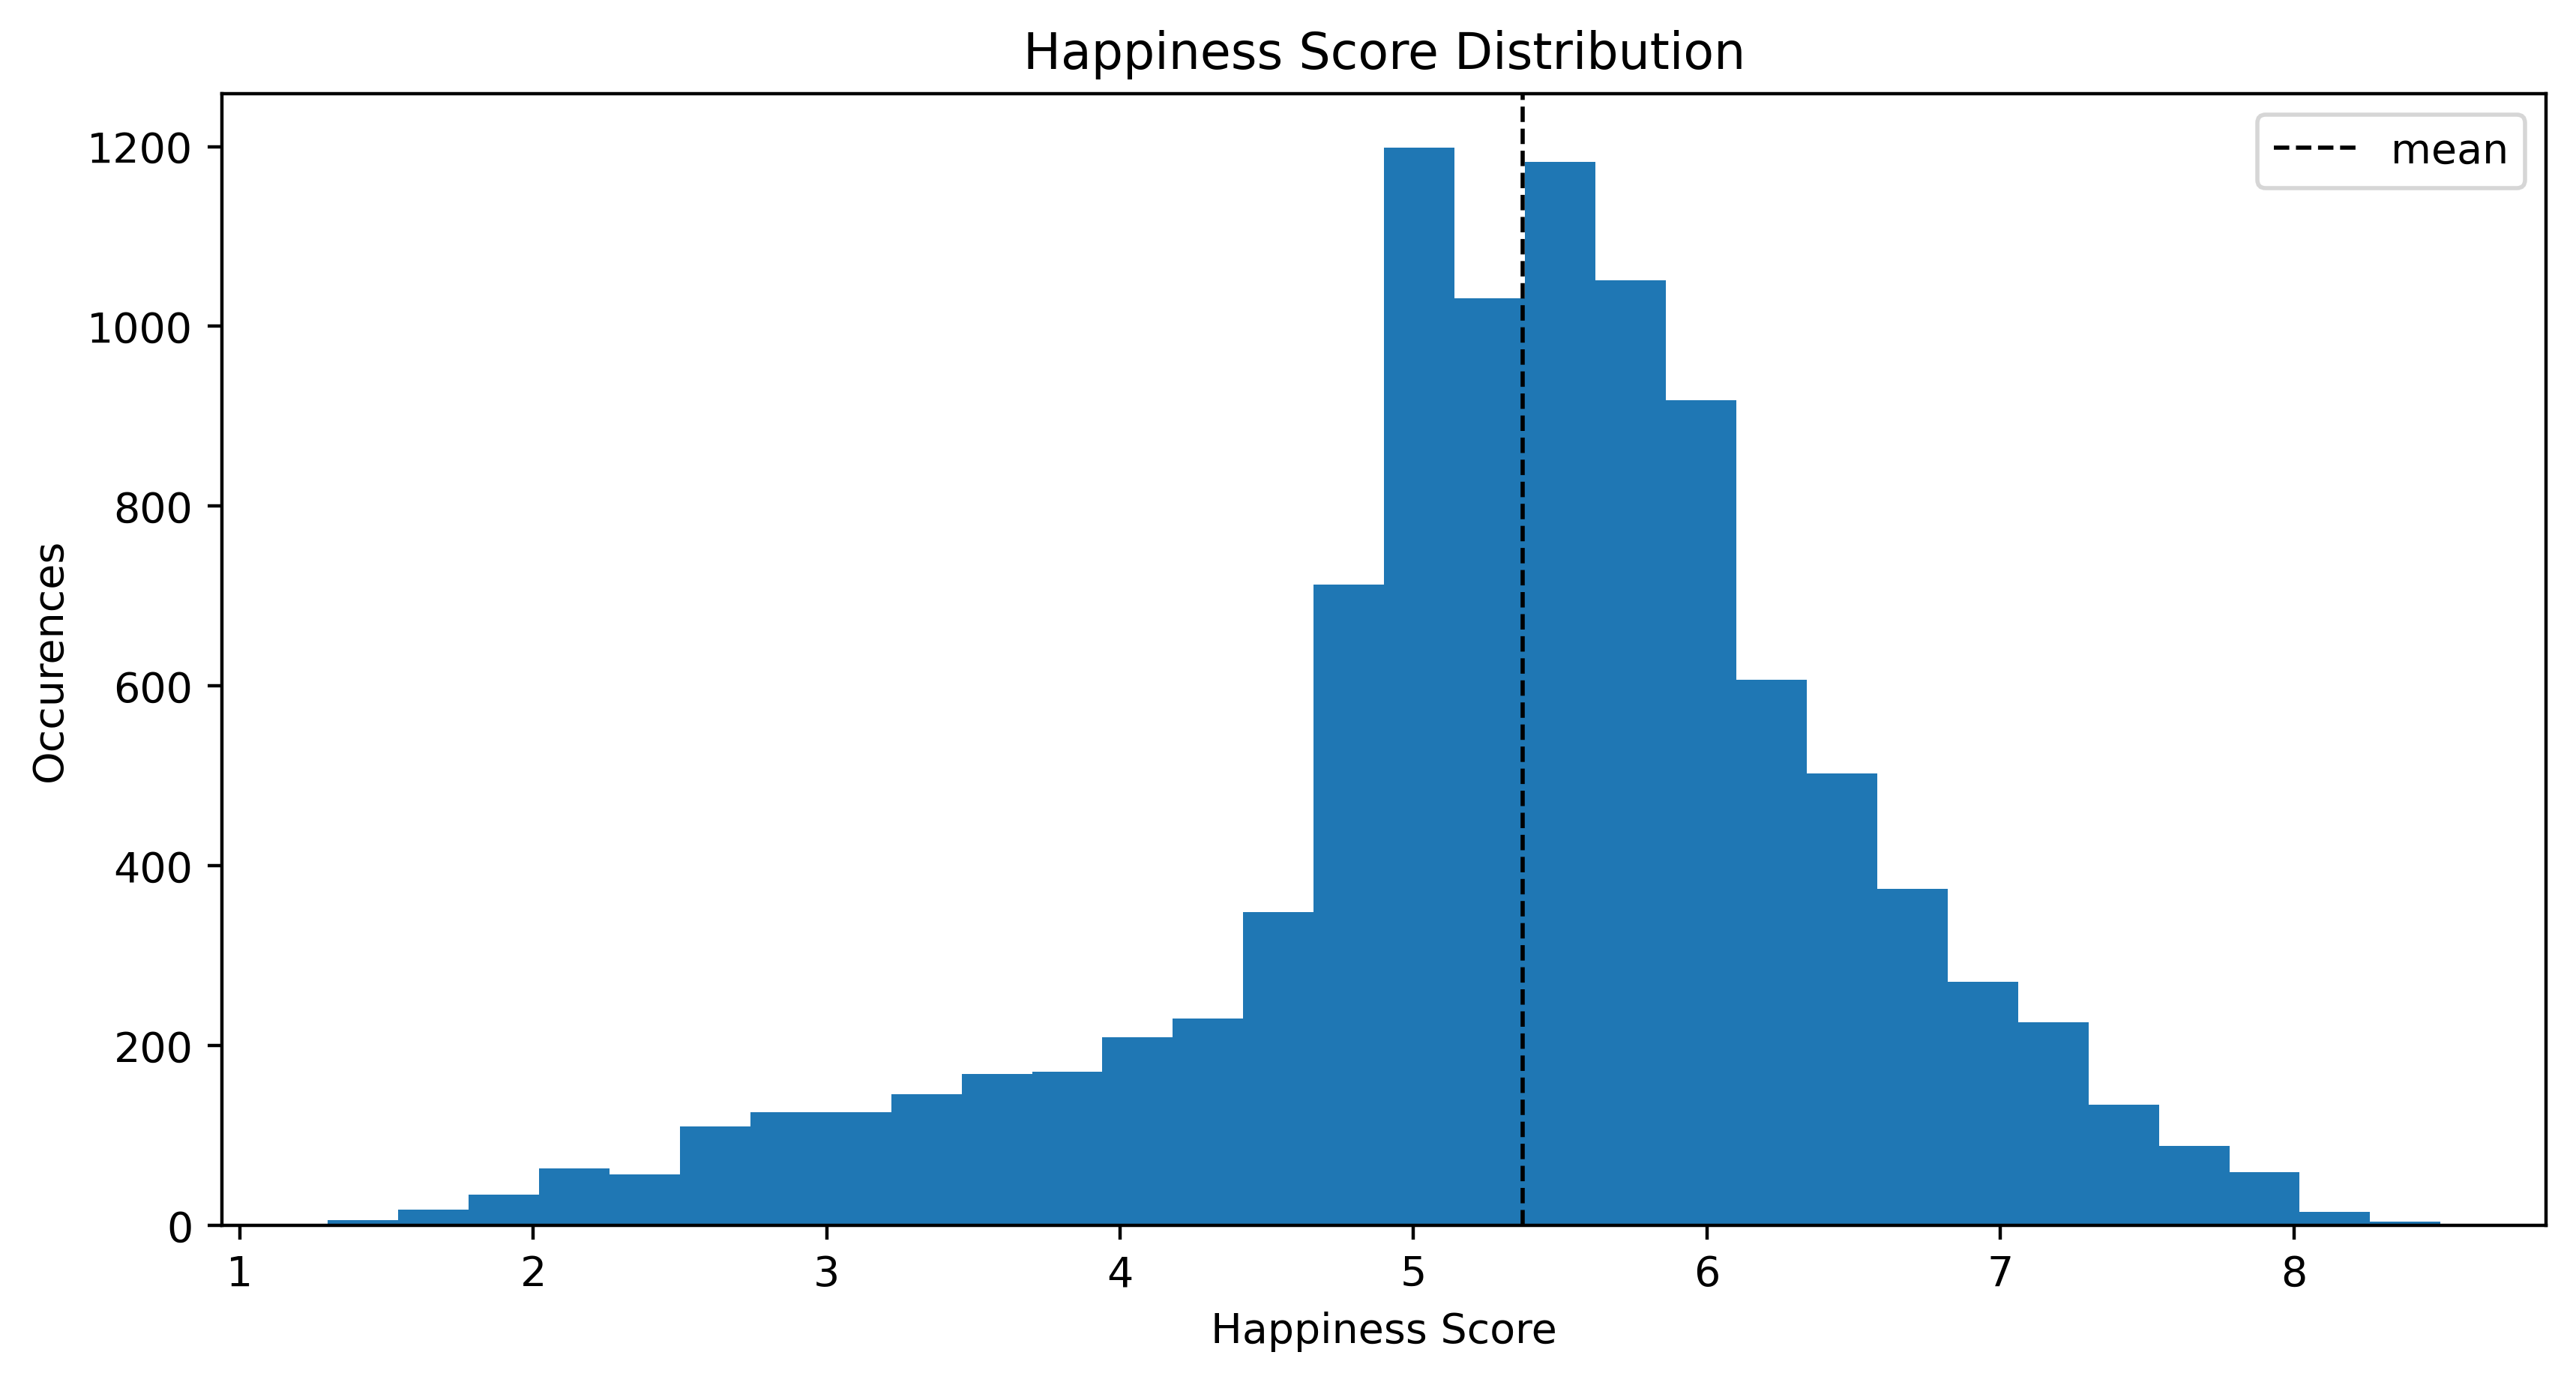

In [5]:
fig, ax = plt.subplots(figsize=(10,5), dpi = 400)
ax.hist(labMT["Happiness Score"].values, bins=30)
ax.axvline(labMT["Happiness Score"].mean(), color='k', linestyle='dashed', linewidth=1, label="mean")
ax.set_title("Happiness Score Distribution")
ax.set_xlabel("Happiness Score")
ax.set_ylabel("Occurences")
ax.legend()
plt.show()

In [6]:
print(f'skewness of happiness scores: {skew(labMT["Happiness Score"].values)}')

skewness of happiness scores: -0.6087457806147994


The skewness measure indicate that the distribution have a moderately skewness to it. More specifically it shows that the distribution have a right sided tail. 

Next step is the creation of two function:

The first function *find_the_happiness* is based upon the formula: 
$$h_{avg}(T)=\sum_{i=1}^{N}h_{avg}(w_i)p_i$$
where $p_i = \frac{f_i}{\sum_{j=1}^{N}f_j}$ and $f_i$ is the frequency of the i'th word $w_i$.

The second function *preprocess* takes a text string as input and tokenizes it, filtering out stop words and punctuation. 

In [7]:
def find_the_happiness(tokens, happiness_df):
    # Initialize happiness
    avg_happiness = 0
    tokens = [word.lower() for word in set(tokens) if word.isalpha() and word in labMT["Word"].values]
    fdist = nltk.FreqDist(tokens)
    N = len(tokens)
    for token in tokens:
        p = fdist[token] / N
        avg_happiness += happiness_df['Happiness Score'][happiness_df['Word'] == token].item() * p
    return avg_happiness

def preprocess(text):
    #Common english stop words
    stop_words = set(stopwords.words('english'))
    #Tokenize using nltk
    word_tokens = word_tokenize(text.lower())
    #removing none letter characters and stop words
    filtered_sentence = [word for word in word_tokens if word not in stop_words and word.isalpha()]
    return filtered_sentence

In the following steps the data is tokenized.

In [9]:
ParlaMint["tokens"] = ParlaMint["Text"].progress_apply(lambda x: preprocess(x))

552103it [32:25, 283.72it/s] 


In [8]:
# Create new column in datetime.date format based on the "From" column.
ParlaMint["date"] = ParlaMint["From"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())

Since the data column descripting if each speaker is a member of the coalition or opposition is filtered out the initial sentimental analysis is done on the two major party from the coalition and the opposition. Namely the Labour party and the Conservative party.

In [18]:
labour_df = ParlaMint[ParlaMint["Speaker_party_name"] == "Labour"]
conservative_df = ParlaMint[ParlaMint["Speaker_party_name"] == "Conservative"]

In [19]:
token_pr_date_labour = labour_df.groupby("date").tokens.sum()
token_pr_date_conservative = conservative_df.groupby("date").tokens.sum()

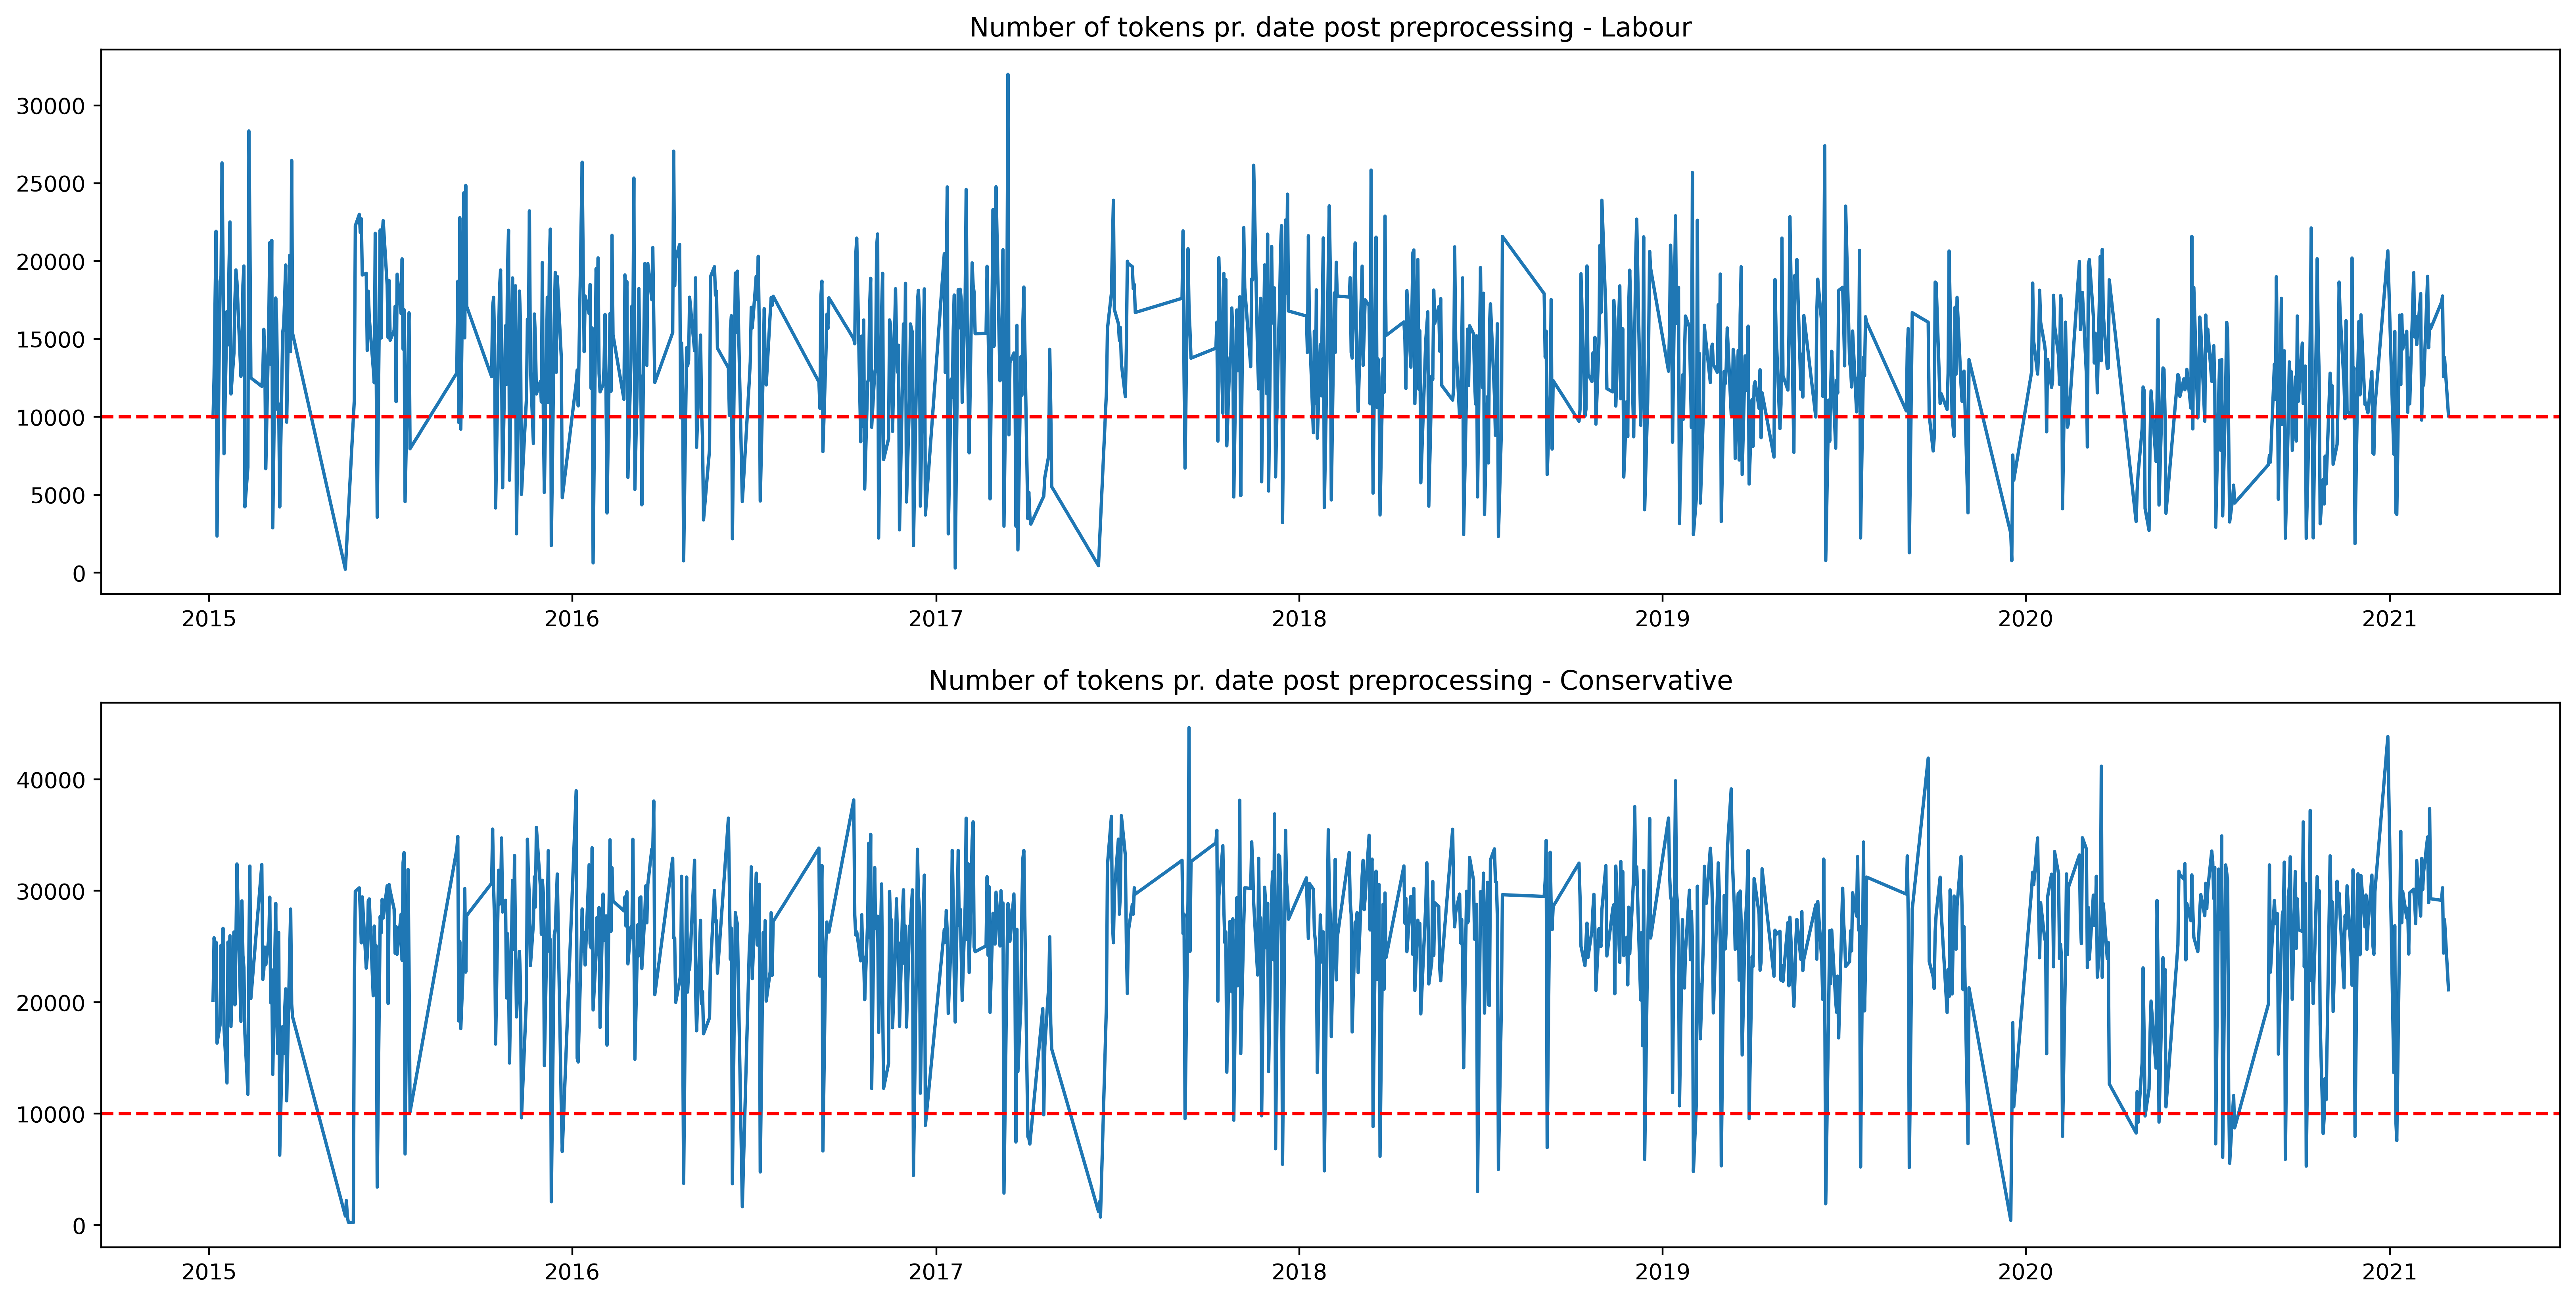

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10), dpi=400)
ax1.plot(token_pr_date_labour.index, [len(x) for x in token_pr_date_labour])
ax1.set_title("Number of tokens pr. date post preprocessing - Labour")
# Add some labels
ax1.axhline(10000, linestyle = "--", color = "r")

ax2.plot(token_pr_date_conservative.index, [len(x) for x in token_pr_date_conservative])
ax2.set_title("Number of tokens pr. date post preprocessing - Conservative")
# Add some labels
ax2.axhline(10000, linestyle = "--", color = "r")

plt.show()

Since dictionary based methods need a large document size to work properly, it is seen from the above plot that especially the Labour document is on the limit of wheather the sentiment analysis yields a reliable result. With the Conservative document only a few days are below the recommended token size of 10000 words. This also reflect that over the entire period of the dataset, Conservative is the larger party.

In [13]:
labour_avg_token = np.mean([len(x) for x in token_pr_date_labour])
conservative_avg_token = np.mean([len(x) for x in token_pr_date_conservative])
print(f"Mean number for token pr date for Labour: {labour_avg_token}")
print(f"Mean number for token pr date for Conservative: {conservative_avg_token}")

Mean number for token pr date for Labour: 13827.087460484721
Mean number for token pr date for Conservative: 25141.098532494758


In [14]:
token_pr_date_labour = token_pr_date_labour.to_frame()
token_pr_date_conservative = token_pr_date_conservative.to_frame()
token_pr_date_labour.columns = ["document"]
token_pr_date_conservative.columns = ["document"]

In [ ]:
# Now for the happiness
token_pr_date_labour["daily_happiness"] = token_pr_date_labour["document"].progress_apply(lambda x: find_the_happiness(x, labMT))

In [ ]:
token_pr_date_conservative["daily_happiness"] = token_pr_date_conservative["document"].progress_apply(lambda x: find_the_happiness(x, labMT))

Save the previous computations so they don't have to be repeated. 

In [ ]:
token_pr_date_labour.to_csv("data/token_pr_date_labour.csv")
token_pr_date_conservative.to_csv("data/token_pr_date_conservative.csv")

Load in the data if stored.

In [53]:
token_pr_date_labour = pd.read_csv("data/token_pr_date_labour.csv")
token_pr_date_conservative = pd.read_csv("data/token_pr_date_conservative.csv")
token_pr_date_labour["date"] = token_pr_date_labour["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())
token_pr_date_conservative["date"] = token_pr_date_conservative["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())
token_pr_date_labour.set_index("date", inplace = True)
token_pr_date_conservative.set_index("date", inplace = True)

Here some days of interest are highlighted. 

In [54]:
#Dates of note
election_days = [datetime.strptime("2015-05-07", "%Y-%m-%d").date(), datetime.strptime("2017-06-08", "%Y-%m-%d").date(), datetime.strptime("2019-12-12", "%Y-%m-%d").date()]
brexit_vote = datetime.strptime("2016-06-23", "%Y-%m-%d").date()
covid_lockdown = datetime.strptime("2020-03-23", "%Y-%m-%d").date()

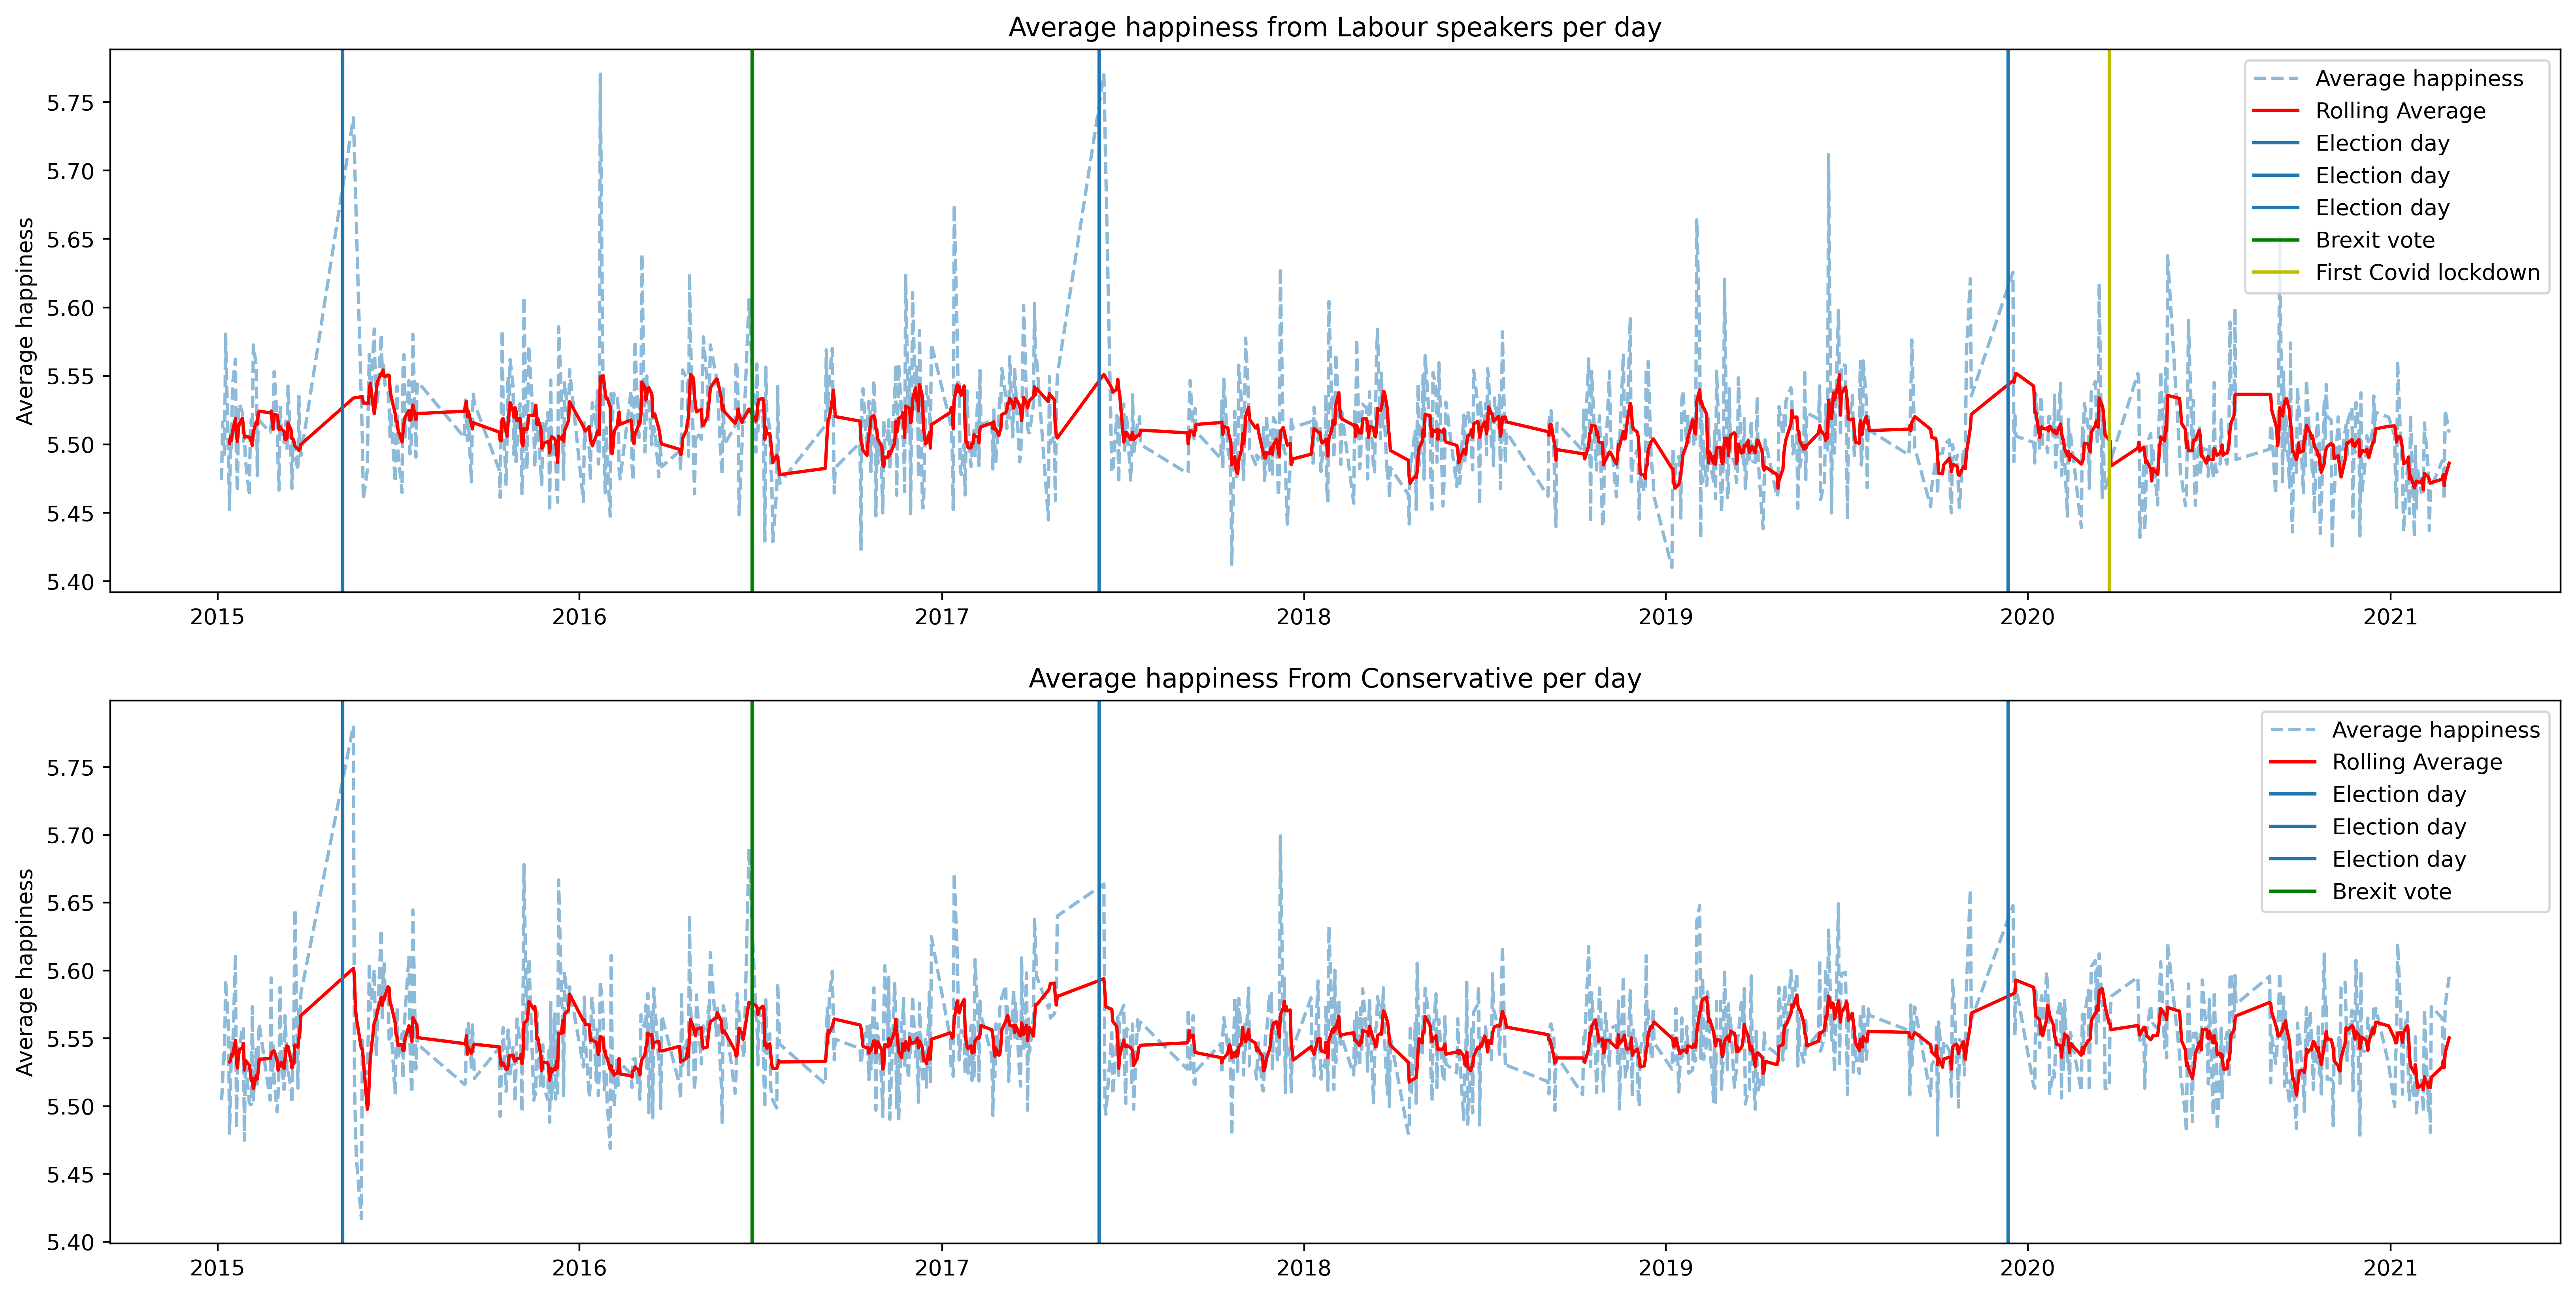

In [55]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10), dpi=400)
rolled_series = token_pr_date_labour["daily_happiness"].rolling(7).mean()
ax1.plot(token_pr_date_labour.index, token_pr_date_labour["daily_happiness"], ls = "--", alpha = 0.5, label='Average happiness')
ax1.plot(rolled_series.index, rolled_series.values, color = "r", label='Rolling Average')
for idx in range(len(election_days)):
    ax1.axvline(election_days[idx], label = "Election day")
ax1.axvline(brexit_vote, label = "Brexit vote", color = "g")
ax1.axvline(covid_lockdown, color = "y", label = "First Covid lockdown")
ax1.set_title("Average happiness from Labour speakers per day")
ax1.set_ylabel("Average happiness")
ax1.legend()

rolled_series2 = token_pr_date_conservative["daily_happiness"].rolling(7).mean()
ax2.plot(token_pr_date_conservative.index, token_pr_date_conservative["daily_happiness"], ls = "--", alpha = 0.5, label='Average happiness')
ax2.plot(rolled_series2.index, rolled_series2.values, color = "r", label='Rolling Average')
for idx in range(len(election_days)):
    ax2.axvline(election_days[idx], label = "Election day")
ax2.axvline(brexit_vote, label = "Brexit vote", color = "g")
ax2.set_title("Average happiness From Conservative per day")
ax2.set_ylabel("Average happiness")
ax2.legend()

plt.show()

Plot need some more work

In [56]:
mean_labour_happiness = np.mean(token_pr_date_labour["daily_happiness"].values)
mean_conservative_happiness = np.mean(token_pr_date_conservative["daily_happiness"].values)
print(f"Mean Labour happiness score: {mean_labour_happiness}")
print(f"Mean Conservative happiness score: {mean_conservative_happiness}")

Mean Labour happiness score: 5.508579469270198
Mean Conservative happiness score: 5.5480341116436005


In [57]:
token_pr_date_labour["daily_happiness"].corr(token_pr_date_conservative["daily_happiness"])

0.5950086078205029

As seen from the plots and the mean happiness score for each party there are not great fluctuations, either over time and between the two parties. This is mainly attributed to the text being in a highly formal setting and the words choosen reflects that. Since most MP make use of this language, though they highly disagree on topics, it pushes the sentiment score towards the neutral 5. It is interesting however, that the sentiment score is still above 5 in this setting, again showing support to the *Pollyanna hypothesis*.

A correlation of 0.595 between the happiness scores for each party indicates that the sentiment in the parliament follows at some level the same tendencies. This makes sense since there are a natural linkage between the topics addresses by MP in the chronological order the data is presented. Many topic or bills discussed in the house poses a problem where parties differ on which solution is most appropriate.